In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import morknn.matplotlib_themes
from morknn.datasets import mnist_dataset
from morknn.layers import Layer
from morknn.net import Net

%config InlineBackend.figure_formats = ['svg']

In [2]:
train_x, train_y, val_x, val_y = mnist_dataset(split_factor=0.05, verbose=False)

In [3]:
def one_hot(data_y):
    n_labels = data_y.shape[0]
    n_options = int(data_y.max())
    one_hoty = np.zeros((n_labels, n_options + 1))
    one_hoty[np.arange(n_labels), data_y] = 1
    return one_hoty.reshape(*one_hoty.shape)

def uno_plot(data_x):
    fig, ax = plt.subplots(1, figsize=(2, 2))
    ax.imshow(data_x[0].reshape(28, 28))
    plt.axis('off')
    plt.tight_layout()
    
def data_shapes(data_x, data_y):
    data_y_oh = one_hot(data_y)
    print(f'first image is a: {data_y[0]}')
    print(f'in OH form, it\'s: {data_y_oh[0]} --> {np.argmax(data_y_oh[0])}')
    print(f'the image.......:')
    uno_plot(data_x)

first image is a: 8
in OH form, it's: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] --> 8
the image.......:


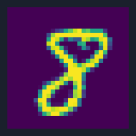

In [4]:
data_shapes(train_x, train_y)

In [5]:
# model parameters
n_options_y = train_y.max() + 1
model_outputs = n_options_y
n_training_images, n_pixels_per_image = train_x.shape
layer_0_output = model_outputs
layer_1_input = layer_0_output

model = Net()
layers = [
    Layer(n_pixels_per_image, layer_0_output, 'relu', dtype=np.float32, name='input'),
    # Layer(layer_1_input, model_outputs, 'relu', dtype=np.float32, name='hidden_1'),
    Layer(model_outputs, model_outputs, 'softmax', dtype=np.float32, name='output'),
]
model.define(layers=layers)
print(model)

LAYER:
 -        name: 'input'
 - weights_dim: (10, 784)
 -    bias_dim: (10, 1)
 -       dtype: <class 'numpy.float32'>
 -  activation: <Activation: 'relu'>
        
LAYER:
 -        name: 'output'
 - weights_dim: (10, 10)
 -    bias_dim: (10, 1)
 -       dtype: <class 'numpy.float32'>
 -  activation: <Activation: 'softmax'>
        


In [24]:
n_images, n_pixels = train_x.shape
learning_rate = 0.005
batch_size = 100
epochs = 40
train_y_oh = one_hot(train_y)

def prepare_batch(train_x, train_y, batch_step=0, batch_size=100):
    indices = np.random.permutation(batch_size)
    batch_x = train_x[
        batch_step * batch_size: min(batch_step * batch_size + batch_size, n_images)
    ][indices]
    batch_y = train_y_oh[
        batch_step * batch_size: min(batch_step * batch_size + batch_size, n_images)
    ][indices]
    return batch_x, batch_y

def shaper(n, w, b, x):
    return f'layer_{n:02d}: ({w[0]:03d}, {w[1]:03d}) * ({x[0]:03d}, {x[1]:03d}) + ({b[0]:02d}, {b[1]:02d})'

def forward_prop(model, batch_x, verbose=True):
    layer_outputs = {'a': [], 'z': []}
    if verbose:
        print('____________FORWARD PROPAGATION_____________')
        print('layer_nn: (_weight_) * (batch_x_) + (_bias_)')
    for n, layer in enumerate(model.layers):
        if n == 0:
            if verbose:
                print(shaper(n, layer.weights.shape, layer.bias.shape, batch_x.T.shape))
            batch_z = np.matmul(layer.weights, batch_x.T) + layer.bias
            batch_a = layer.activation.activation(batch_z)
        else:
            if verbose:
                print(shaper(n, layer.weights.shape, layer.bias.shape, batch_a.shape))
            batch_z = np.matmul(layer.weights, batch_a) + layer.bias
            batch_a = layer.activation.activation(batch_z)
        layer_outputs['a'].append(batch_a)
        layer_outputs['z'].append(batch_z)
    return layer_outputs

def back_prop(layer_outputs, batch_x, batch_y, verbose=True):
    n = -1    
    dz = np.subtract(layer_outputs['a'][n].T, batch_y)
    a_n2 = layer_outputs['a'][n-1]

    print(f'dz.T: {dz.T.shape}, a_n2.T: {a_n2.T.shape} = ({dz.T.shape[0]}, {a_n2.T.shape[-1]})')
    delta_w = np.matmul(dz.T, a_n2.T) / batch_size
    delta_b = np.sum(dz.T, axis=1, keepdims=True) / batch_size
    
    if verbose:
        print('')
        print('____________BACKWARD PROPAGATION____________')
        print(f'Layer {n:02d}')
        print(f'dz * a_n2 = {dz.shape} * {a_n2.shape} = ({dz.shape[0]}, {a_n2.shape[-1]})')
        print(f'  dW: {dz.T.shape} * {a_n2.T.shape} = {delta_w.shape}')
        print(f'  dB: {delta_b.shape}')
        print(f'----')

    # UPDATE WEIGHTS & BIAS
    print(f'w: {model.layers[n].weights.shape}, dW: {delta_w.shape}')
    model.layers[n].weights = model.layers[n].weights - learning_rate * delta_w
    model.layers[n].bias = model.layers[n].bias - learning_rate * delta_b
    
    # (A_n − Y) * W_n * σ′(Z_n1) * A_n2
    n = -2
    print('')
    print(f'Layer {n:02d}')
    
    """
        one_hot_Y = one_hot(Y)
        dZ2 = A2 - one_hot_Y
        dW2 = 1 / m * dZ2.dot(A1.T)
        db2 = 1 / m * np.sum(dZ2)
        dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
        dW1 = 1 / m * dZ1.dot(X.T)
        db1 = 1 / m * np.sum(dZ1)
        return dW1, db1, dW2, db2
    """

    w_n0 = model.layers[n+1].weights
    
    print(layer_outputs['z'][0].shape)
    print(layer_outputs['z'][1].shape)
    da_n1 = model.layers[n+1].activation.d_activation(layer_outputs['z'][n+1])
    if n + len(layer_outputs['a']) == 0:
        a_n2 = batch_x
    else:
        a_n2 = layer_outputs['a'][n-1]
    print(f'    dZ: {dz.shape}')
    print(f'  W_n0: {w_n0.shape}')
    print(f' da_n1: {da_n1.shape}')
    print(f'data_x: {a_n2.shape}')
    
    delta_w = np.matmul(da_n1, a_n2)
    delta_w = np.matmul(w_n0, delta_w)
    delta_w = np.matmul(dz, delta_w)
    
    print(f'    dW: {delta_w.shape}')
    model.layers[n].weights = model.layers[n].weights - learning_rate * delta_w
    model.layers[n].bias = model.layers[n].bias - learning_rate * delta_b

batch_x, batch_y = prepare_batch(train_x, train_y, batch_step=0, batch_size=5)
layer_outputs = forward_prop(model, batch_x)
back_prop(layer_outputs, batch_x, batch_y)

____________FORWARD PROPAGATION_____________
layer_nn: (_weight_) * (batch_x_) + (_bias_)
layer_00: (010, 784) * (784, 005) + (10, 01)
layer_01: (010, 010) * (010, 005) + (10, 01)
dz.T: (10, 5), a_n2.T: (5, 10) = (10, 10)

____________BACKWARD PROPAGATION____________
Layer -1
dz * a_n2 = (5, 10) * (10, 5) = (5, 5)
  dW: (10, 5) * (5, 10) = (10, 10)
  dB: (10, 1)
----
w: (10, 10), dW: (10, 10)

Layer -2
(10, 5)
(10, 5)
    dZ: (5, 10)
  W_n0: (10, 10)
 da_n1: (10, 5)
data_x: (5, 784)
    dW: (5, 784)


ValueError: operands could not be broadcast together with shapes (10,784) (5,784) 

In [7]:
n_images, n_pixels = train_x.shape
learning_rate = 0.005
batch = 100
epochs = 40
train_y_oh = one_hot(train_y)

def forward(model, data_x):
    z = np.add(np.matmul(model.weights, data_x.T), model.bias)
    a = model.activation.activation(z)
    return z, a

def predict(batch_x, batch_y):
    z, a = forward(model, batch_x)
    y_hat = np.argmax(a, axis=0)
    y_ = np.argmax(batch_y, axis=1)
    accuracy = (y_hat == y_).mean()
    return accuracy

verbose = True
accuracy_value = []
loss_value = []

for epoch in range(epochs):
    if verbose:
        print(f'epoch: {epoch}')
    for n in range(int(n_images / batch)):
        indices = np.random.permutation(batch)
        batch_x = train_x[n*batch: min(n * batch + batch, n_images)][indices]
        batch_y = train_y_oh[n*batch: min(n * batch + batch, n_images)][indices]

        # FORWARD
        z, a = forward(model, batch_x)

        # BACKWARD
        error = np.subtract(a.T, batch_y)
        delta_w = np.matmul(error.T, batch_x) / batch
        delta_b = np.sum(error.T, axis=1, keepdims=True) / batch

        # LOSS
        loss = -np.mean(batch_y * np.log(a.T))
        pred = predict(batch_x, batch_y)
        loss_value.append(loss)
        accuracy_value.append(pred)

        # UPDATE WEIGHTS & BIAS
        model.weights = model.weights - learning_rate * delta_w
        
        model.bias = model.bias - learning_rate * delta_b
        if n % 100 == 0 and verbose:
            print(f'  step={n:03d}/{int(n_images / batch)} loss={loss:.5f}, accuracy={pred:.3f}')

epoch: 0
  step=000/399 loss=0.84311, accuracy=0.100
  step=100/399 loss=0.72504, accuracy=0.130
  step=200/399 loss=0.56047, accuracy=0.220
  step=300/399 loss=0.55765, accuracy=0.110
epoch: 1
  step=000/399 loss=0.43487, accuracy=0.180
  step=100/399 loss=0.44036, accuracy=0.230
  step=200/399 loss=0.33795, accuracy=0.320
  step=300/399 loss=0.38217, accuracy=0.260
epoch: 2
  step=000/399 loss=0.28380, accuracy=0.330
  step=100/399 loss=0.30757, accuracy=0.300
  step=200/399 loss=0.22982, accuracy=0.470
  step=300/399 loss=0.29151, accuracy=0.340
epoch: 3
  step=000/399 loss=0.20660, accuracy=0.500
  step=100/399 loss=0.23869, accuracy=0.380
  step=200/399 loss=0.17694, accuracy=0.540
  step=300/399 loss=0.24045, accuracy=0.420
epoch: 4
  step=000/399 loss=0.16537, accuracy=0.580
  step=100/399 loss=0.20089, accuracy=0.500
  step=200/399 loss=0.14662, accuracy=0.620
  step=300/399 loss=0.20816, accuracy=0.490
epoch: 5
  step=000/399 loss=0.14058, accuracy=0.650
  step=100/399 loss=0.

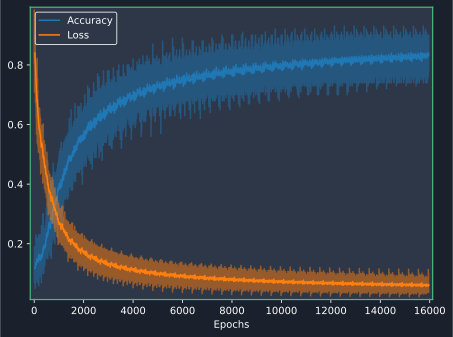

In [13]:
fig, ax = plt.subplots(1)
ax.plot(accuracy_value, color='C0', alpha=0.5)
ax.plot(pd.Series(accuracy_value).rolling(30).mean(), color='C0', label=f'Accuracy')
ax.plot(loss_value, color='C1', alpha=0.5)
ax.plot(pd.Series(loss_value).rolling(30).mean(), color='C1', label=f'Loss')
ax.set_xlabel(f'Epochs')
ax.legend()
plt.tight_layout()

[1 0 1 7 0 0 7 3 5 3]


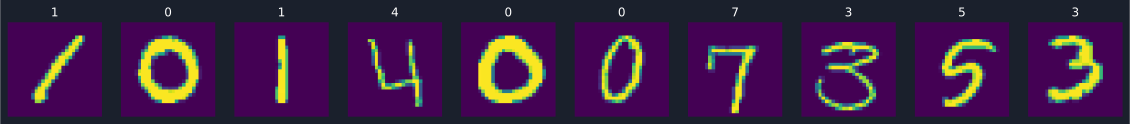

In [10]:
def predict_(batch_x, batch_y):
    z, a = forward(model, batch_x)
    y_hat = np.argmax(a, axis=0)
    y_ = np.argmax(batch_y, axis=1)
    accuracy = (y_hat == y_).mean()
    return accuracy

def forward_(model, data_x):
    z = np.add(np.matmul(model.weights, data_x.T), model.bias)
    a = model.activation.activation(z)
    return z, a


n = 10
z, a = forward_(model, val_x[:n])
print(np.argmax(a, axis=0))

fig, axes = plt.subplots(1, n, figsize=(2 * n, 2.4))
for im, label, ax in zip(val_x[:n], val_y[:n], axes):
    ax.imshow(im.reshape(28, 28))
    ax.axis('off')
    ax.set_title(label)

## Multiply 2 matrices

$$
\large{
\mathbf{C}_{q, p} = \mathbf{A}_{q, n} \cdot \mathbf{B}_{n, p}\,, \qquad \text{where}\,\qquad  c_{i, j} = \sum_{k=0}^{n}a_{i, k}b_{k, j}
}
$$

## the math

$$
\large{\begin{align}
\mathbf{\hat{Y}} &= \mathbf{\sigma}\left\{\mathbf{Z}\right\}\\
\mathbf{\hat{Y}} &= \mathbf{\sigma} \left\{ \mathbf{W} \cdot \mathbf{X} + \mathbf{B}\right\}\\
\end{align}}
$$

the shape of each element is

$$
\large{\begin{align}
    \mathbf{X}_{784, 1}&=\left(
        \begin{matrix}
            x_0 \\ x_1 \\ \vdots \\ x_{783}
        \end{matrix}\right)\\[10pt]
\mathbf{W}_{10, 784}&=\left( 
    \begin{matrix}
        w_{0, 0} & w_{0, 1} & \dots & w_{0, 783} \\
        w_{1, 0} & w_{1, 1} & \dots & w_{1, 783} \\ 
        \vdots   & \vdots   & \ddots& \vdots     \\ 
        w_{9, 0} & w_{9, 1} & \dots & w_{9, 783} \\ 
    \end{matrix}\right)\\[10pt]
    \mathbf{B}_{10, 1}&=\left(
        \begin{matrix}
            b_0 \\ b_1 \\ \vdots \\ b_{9}
        \end{matrix}\right)
\end{align}}
$$

Going from $\mathbf{X}$ (_inout image data_) to $\mathbf{\hat{Y}}$ (_output label data_), do the following _forward pass_. 

$$
\large{\begin{align}
    \mathbf{\hat{Y}}&=\sigma\left\{ \mathbf{Z} \right\}\\
    \mathbf{\hat{Y}}&=\sigma\left\{ \mathbf{W} \cdot \mathbf{X} + \mathbf{B} \right\}\\
    \mathbf{\hat{Y}}_{10, 1}&=\sigma \bigg\{\, \underbrace{\mathbf{W}_{10, 784} \cdot \mathbf{X}_{784, 1}}_{\mathbf{R}_{10, 1}} + \mathbf{B}_{10, 1} \bigg\}\\
    \mathbf{\hat{Y}}_{10, 1}&=\sigma\left\{ \mathbf{R}_{10, 1} + \mathbf{B}_{10, 1} \right\}\\
    \mathbf{\hat{Y}}_{10, 1}&=\sigma\left\{ \mathbf{Z}_{10, 1} \right\}\\
    \mathbf{\hat{Y}}_{10, 1}&=\mathbf{A}_{10, 1}
\end{align}}
$$

## Loss function

The loss function (see [link](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html))

$$
\large{\begin{align}
\mathcal{L}=-\sum_{i=0}^{c}y_i\ln\left( a_i \right)
\end{align}}
$$

## back-propagation

$$
\large{\begin{align}
\frac{\mathcal{L}}{d\mathbf{W}^l}&=\left( \mathbf{A}^l - \mathbf{\hat{Y}}^l \right) \mathbf{A}^{l-1}\\[4pt]
\frac{\mathcal{L}}{d\mathbf{W}^{l-1}}&=\left( \mathbf{A}^l - \mathbf{\hat{Y}}^l \right) \left( \mathbf{A}^{l-1} - \mathbf{\hat{Y}}^{l-1} \right) \mathbf{A}^{l-2}
\end{align}}
$$

## Define the model in code

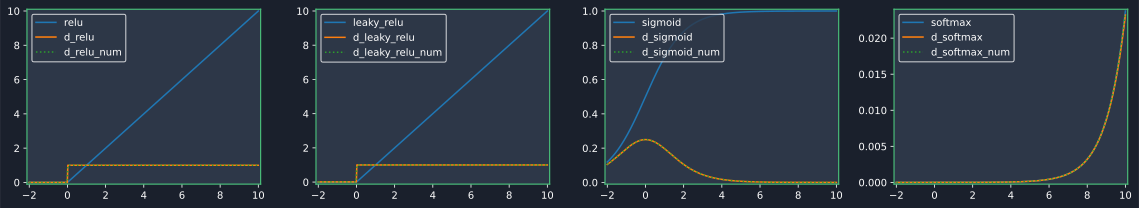

In [14]:
from morknn.activators import Activator

actnames = ['relu', 'leaky_relu', 'sigmoid', 'softmax']
fig, axes = plt.subplots(1, len(actnames), figsize=(16, 3))

for ax, actname in zip(axes, actnames):
    z = np.linspace(-2, 10, 500)
    act = Activator(name=actname)
    y = act._act()(z)
    dy = act._d_act()(z)
    dy_num = act.d_general(z)
    ax.plot(z, y, label=actname)
    ax.plot(z, dy, label=f'd_{actname}')
    ax.plot(z, dy_num, ls=':', label=f'd_{actname}_num')
    ax.legend(loc=2)
plt.tight_layout()